This playbook implements the ILP described in: https://www.overleaf.com/read/tfphxmrnmdqz#5d9206

# PCFI data generation

In [4]:
import ast
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pulp
from scipy.special import softmax
from tqdm.notebook import tqdm
import os
import time
import itertools

In [5]:
disable_tqdm = True

In [6]:
n_classes = 20
n_features = 15
phis = list(map(np.array, itertools.product([0, 1], repeat=n_features)))[1:-1]
features_list = list(pd.read_csv('importance_weights.csv').drop(columns=['c_name']).columns)
unwanted_classes = ['Blipcare Blood Pressure meter', 'IPhone']

In [7]:
test_classes_list = ['Amazon Echo', 'Android Phone', 'Belkin Wemo switch', 'Belkin wemo motion sensor',  'Dropcam', 'HP Printer', 'Insteon Camera', 'Laptop', 'Light Bulbs LiFX Smart Bulb', 'MacBook', 'NEST Protect smoke alarm', 'Netatmo Welcome', 'Netatmo weather station', 'PIX-STAR Photo-frame', 'Samsung Galaxy Tab', 'Samsung SmartCam', 'Smart Things', 'TP-Link Day Night Cloud camera', 'TP-Link Smart plug', 'Triby Speaker']
test_classes_list.sort()
test_classes_list = None

In [8]:
test_classes_list

In [9]:
def generate_test_problem_data(test_classes_list,  n_features=15):
    classes_list = test_classes_list
    W = pd.read_csv('importance_weights.csv').set_index('c_name').loc[classes_list].values[:,:n_features]
    F = pd.read_csv('score_per_class.csv').set_index('class').loc[classes_list].sort_values(by='class')['f1_score'].to_list()
    return W, F, classes_list

# W, F, classes_list = generate_problem_data(test_classes_list)
# n_classes = len(classes_list)

def generate_problem_data(n_classes, n_features):
    if n_classes == 24:
        pcfi_data = pd.read_csv('importance_weights.csv').set_index('c_name')
        W = pcfi_data.loc[~pcfi_data.index.isin(unwanted_classes)]
        usable_classes_list =  W.index.to_list()
        classes_list = usable_classes_list
    else:
        pcfi_data = pd.read_csv('importance_weights.csv').set_index('c_name')
        W = pcfi_data.loc[~pcfi_data.index.isin(unwanted_classes)].values[:n_classes,:n_features]
        classes_list = pcfi_data.loc[~pcfi_data.index.isin(unwanted_classes)].index.to_list()[:n_classes]
        # classes_list = list(pd.read_csv('importance_weights.csv')['c_name'].values)[:n_classes]
        
    F1_data = pd.read_csv('score_per_class.csv').set_index('class')
    F1_data = F1_data.loc[~F1_data.index.isin(unwanted_classes)]
    F = F1_data.sort_values(by='class')['f1_score'].to_list()[:n_classes]
    return W, F, classes_list

W, F, classes_list = generate_problem_data(n_classes, n_features)

In [10]:
W.shape

(20, 15)

In [11]:
assert(classes_list == ['Amazon Echo', 'Android Phone', 'Belkin Wemo switch',
       'Belkin wemo motion sensor', 
       'Dropcam', 'HP Printer', 'Insteon Camera', 'Laptop',
       'Light Bulbs LiFX Smart Bulb', 'MacBook',
       'NEST Protect smoke alarm', 'Netatmo Welcome',
       'Netatmo weather station', 'PIX-STAR Photo-frame',
       'Samsung Galaxy Tab', 'Samsung SmartCam', 'Smart Things',
       'TP-Link Day Night Cloud camera', 'TP-Link Smart plug',
       'Triby Speaker'])

In [12]:
# W, F, classes_list = generate_test_problem_data(test_classes_list)
# n_classes = len(classes_list)

For testing purposes, you might want to pick a set of classes at random. Uncomment accordingly

In [13]:
# class_idx = np.random.randint(0,25,12)
#class_idx_list = np.random.choice(25, 12, replace=False)
#pd.read_csv('importance_weights.csv').iloc[class_idx_list]['c_name'].to_list()
# print(class_idx_list)

Throughout this notebook, the order of the classes is important because we perform binary encoding in the problem formulation. Below, we check that how the performed ordering results:

In [14]:
pd.read_csv('score_per_class.csv').set_index('class').loc[classes_list].sort_values(by='class')

,Unnamed: 0,f1_score,support
class,,,
Amazon Echo,3,96.684257,4649.0
Android Phone,12,50.347747,1525.0
Belkin Wemo switch,11,88.919104,2003.0
Belkin wemo motion sensor,5,95.942556,3282.0
Dropcam,23,19.178082,4.0
HP Printer,7,64.355210,727.0
Insteon Camera,1,93.822807,6888.0
Laptop,0,94.084491,11484.0
Light Bulbs LiFX Smart Bulb,14,99.836551,1509.0


# Cost Computation

In case you want to generate random data, uncomment the below cell

In [15]:
# W = softmax(np.array([[random.random() for i in range(10)] for j in range(10)]), 1)

Verify the binary encoding of groups. A 1 in the ith position indicates that the ith class is considered for the group.

In [16]:
s_j = np.random.randint(2, size=n_classes)
print(s_j)

[0 0 0 0 1 0 0 1 0 1 1 1 0 0 0 0 1 1 0 1]


In [17]:
def onehot(y, max=n_classes):
    """Returns the one-hot encoding of the input
    
    Parameters
    ----------
    y: int
    The value to be encoded
    max: int
    The max encodable value, i.e, the length of the array.

    Returns
    -------
    tuple
        The one-hot encoding of the input, y.
    """
    return tuple([1 if x+1 == y else 0 for x in range(max)])
onehot(1)

(1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

Phis is the list of all possible feature combinations, each binary encoded. We remove the empty and full options.

In [18]:
phis = list(map(np.array, itertools.product([0, 1], repeat=n_features)))
assert len(phis) == 2 ** n_features
phis = phis[1:-1]

The below cell purpose is to verify the dimensions of vectors and matrices. If it does not throw an error, everything is fine.

In [19]:
(W @ phis[100])

array([0.54790983, 0.31081991, 0.15789767, 0.17763737, 0.45485364,
       0.17168096, 0.54052843, 0.43300595, 0.53776015, 0.50626017,
       0.2912783 , 0.33536419, 0.30057658, 0.63232646, 0.29911859,
       0.40096461, 0.40024609, 0.54057994, 0.44909094, 0.33577347])

In [20]:
s_j @ (W @ phis[100]) - np.ones(n_features) @ phis[100]

-0.7026382363624157

Below is an example of how the best features combination is selected, via an exhaustive search. Later we use a closed-form solution.

In [21]:
max_values = np.array([s_j @ (W @ phi) - np.ones(n_features) * (1 / n_features) * (np.ones(n_classes) @ s_j) @ phi for phi in phis])
res = np.argmax(max_values)
print(f'The index providing the max is: {res}')
phi_star = phis[res]
print(phi_star)
print(max_values[res])

The index providing the max is: 246
[0 0 0 0 0 0 0 1 1 1 1 0 1 1 1]
2.5015238277068055


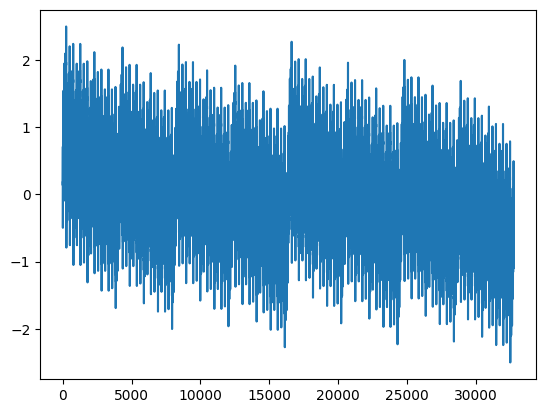

In [22]:
plt.plot(max_values)

In [23]:
# This should match the total importance of the selected classes, i.e., the sum of the ones in s_j
total_possible_importance = np.ones(n_features)*(1/n_features)*(np.ones(n_classes)@s_j) @ np.ones(n_features)
assert s_j.sum() - total_possible_importance < 0.01
print(total_possible_importance)

7.999999999999999


In [24]:
# A simpler method is:
np.ones(n_classes)@s_j

8.0

In [25]:
print('The per feature cost is:')
feature_cost = (1 / n_features) * (np.ones(n_features)  * (np.ones(n_classes) @ np.array(onehot(2,n_classes)))) @ onehot(1,n_features)
print(feature_cost)

The per feature cost is:
0.06666666666666667


In [26]:
def compute_group_cost(s_j, W=W):
    """Old version. It does not consider the F1 scores and makes exhaustive search
    """
    n_classes = W.shape[0]
    max_values = np.array([s_j @ (W @ phi) - np.ones(n_features) * (1 / n_features) * (np.ones(n_classes) @ s_j) @ phi for phi in phis])
    res = np.argmax(max_values)
    return n_classes - max_values[res], phis[res]

In [27]:
def compute_group_cost_maximize(s_j, W=W, F=F):
    """Returns the cost of grouping s_j, provided the per class feature
    importance matrix, W, and the F1 scores list F. Also provides the set
    of features leading to such cost.
    
    Parameters
    ----------
    W: numpy.ndarray
    The importance matrix
    F: numpy.ndarray
    The F1 score list of the classes.
    s_j : numpy.ndarray
    The considered grouping

    Returns
    -------
    numpy.float64
        The cost of the grouping
    numpy.ndarray
        The features selected for the grouping
    """
    n_classes = W.shape[0]
    feats = (s_j @ W - np.transpose(np.ones(n_features) * (1 / n_features) * (np.ones(n_classes) @ s_j)))>0
    feats = feats.astype(int)
    cost =  (s_j @ (W @ feats) - np.ones(n_features) * (1 / n_features) * (np.ones(n_classes) @ s_j) @ feats)
    return cost, feats
def compute_group_cost_c4(s_j, W=W,F=F):
    """Returns the cost of grouping s_j, provided the per class feature
    importance matrix, W, and the F1 scores list F. Also provides the set
    of features leading to such cost.
    
    Parameters
    ----------
    W: numpy.ndarray
    The importance matrix
    F: numpy.ndarray
    The F1 score list of the classes.
    s_j : numpy.ndarray
    The considered grouping

    Returns
    -------
    numpy.float64
        The cost of the grouping
    numpy.ndarray
        The features selected for the grouping
    """
    n_classes = W.shape[0]
    feats = (s_j @ W - np.transpose(np.ones(n_features) * (1 / n_features) * (np.ones(n_classes) @ s_j)))>0
    feats = feats.astype(int)
    cost = n_classes - (s_j @ (W @ feats) - np.ones(n_features) * (1 / n_features) * (np.ones(n_classes) @ s_j) @ feats)
    f_scores = np.array(list(itertools.compress(F, s_j)))
    if (sum(s_j) <= 1):
        f_score_cost = np.max(f_scores)
    else:
        f_score_cost = np.ptp(f_scores)
    cost = cost*f_score_cost
    return cost, feats

In [28]:
def compute_group_cost_c4_no_F1(s_j, W=W,F=F):
    """Returns the cost of grouping s_j, provided the per class feature
    importance matrix, W, and the F1 scores list F. Also provides the set
    of features leading to such cost.
    
    Parameters
    ----------
    W: numpy.ndarray
    The importance matrix
    F: numpy.ndarray
    The F1 score list of the classes.
    s_j : numpy.ndarray
    The considered grouping

    Returns
    -------
    numpy.float64
        The cost of the grouping
    numpy.ndarray
        The features selected for the grouping
    """
    n_classes = W.shape[0]
    feats = (s_j @ W - np.transpose(np.ones(n_features) * (1 / n_features) * (np.ones(n_classes) @ s_j)))>0
    feats = feats.astype(int)
    cost = n_classes - (s_j @ (W @ feats) - np.ones(n_features) * (1 / n_features) * (np.ones(n_classes) @ s_j) @ feats)
    return cost, feats

In [29]:
def compute_group_cost_c6(s_j, W=W,F=F):
    """Returns the cost of grouping s_j, provided the per class feature
    importance matrix, W, and the F1 scores list F. Also provides the set
    of features leading to such cost.
    
    Parameters
    ----------
    W: numpy.ndarray
    The importance matrix
    F: numpy.ndarray
    The F1 score list of the classes.
    s_j : numpy.ndarray
    The considered grouping

    Returns
    -------
    numpy.float64
        The cost of the grouping
    numpy.ndarray
        The features selected for the grouping
    """
    max_values = np.array([s_j @ (W @ phi) - np.ones(n_features) * (1 / n_features) * (np.ones(n_classes) @ s_j) @ phi for phi in phis])
    res = np.argmax(max_values)
    return n_classes - max_values[res], phis[res]

In [30]:
def compute_costs(W, S, F, costf=compute_group_cost_c4):
    """Computes, iteratively, the cost of all possible groupings, i.e., over 2 ** n_classes -1 groupings
    """
    c = np.zeros(len(S))
    feats = []
    for j, s_j in enumerate(tqdm(S, disable=disable_tqdm)):
        # c[j], feat = compute_group_cost(s_j)
        c[j], feat = costf(s_j, W, F)
        feats.append(feat)
    return c, feats

In [31]:
compute_group_cost_c4_no_F1(s_j)

(17.498476172293195, array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1]))

In [32]:
# does not consider F1 score, should match the above. It shows that the closed form is equivalent
compute_group_cost(s_j)

(17.498476172293195, array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1]))

In [33]:
compute_group_cost_maximize(s_j)

(2.5015238277068055, array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1]))

Below, we pre-compute the cost of each possible grouping.

In [31]:
S = list(map(np.array, itertools.product([0, 1], repeat=n_classes)))[1:-1]
C, feats =  compute_costs(W, S, F)

# Formulate ILP

In [32]:
possible_partitions = list(map(tuple, itertools.product([0, 1], repeat=n_classes)))[1:-1]

In [33]:
x = pulp.LpVariable.dicts('part', possible_partitions, lowBound=0, upBound=1, cat=pulp.LpInteger)

In [34]:
part_model = pulp.LpProblem('Part_Model', pulp.LpMaximize)

In [35]:
part_model += pulp.lpSum((C[i]*x[part] for i,part in enumerate(possible_partitions)))

**Attention!** Modify the below cell to specify the maximum number of classes

In [36]:
part_model += (
    pulp.lpSum([x[part] for part in possible_partitions]) <= n_classes-1,
    # pulp.lpSum([x[part] for part in possible_partitions]) <= 2,
    "Maximum_number_of_partitions",
)

In [37]:
for i in range(n_classes):
    # print(onehot(i+1, n_classes))
    part_model += (
            pulp.lpSum([x[part] for part in possible_partitions if part[i]==1])==1,
            f"Must_include_{onehot(i+1, n_classes)}",
    )

In [38]:
part_model.solve(solver=pulp.apis.PULP_CBC_CMD(threads=4))

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ddeandres/jupyter/.venv/lib/python3.8/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/9b48a305e4a94b3bb6b53a2a6792342a-pulp.mps -max -threads 4 -timeMode elapsed -branch -printingOptions all -solution /tmp/9b48a305e4a94b3bb6b53a2a6792342a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 26 COLUMNS
At line 14680063 RHS
At line 14680085 BOUNDS
At line 15728660 ENDATA
Problem MODEL has 21 rows, 1048574 columns and 11534314 elements
Coin0008I MODEL read with 0 errors
threads was changed from 0 to 4
Option for timeMode changed from cpu to elapsed
Continuous objective value is 29628.8 - 3.04 seconds
Cgl0004I processed model has 21 rows, 1048574 columns (1048574 integer (1048574 of which binary)) and 11534314 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -29628.8
Cbc0038I Before mini branch and bound, 1048574 integer

1

In [39]:
print(f"The clusters are:")
partition = []
for part in possible_partitions:
    if x[part].value() == 1.0:
        partition.append(list(part))

for part in partition:
    part_labels = [c for mask, c in zip(part,classes_list) if mask==1]
    print(part_labels)
    print("ENCODING:", part)
    print()


The clusters are:
['Triby Speaker']
ENCODING: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

['TP-Link Smart plug']
ENCODING: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]

['TP-Link Day Night Cloud camera']
ENCODING: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]

['Smart Things']
ENCODING: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]

['Samsung SmartCam']
ENCODING: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]

['Samsung Galaxy Tab']
ENCODING: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]

['PIX-STAR Photo-frame']
ENCODING: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]

['Netatmo weather station']
ENCODING: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

['Netatmo Welcome']
ENCODING: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]

['NEST Protect smoke alarm']
ENCODING: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

['Light Bulbs LiFX Smar

In [40]:
# Need to recover which feature each grouping would use

In [41]:
clusters = [sum([2**i for i,val in enumerate(reversed(part)) if val==1]) for part in possible_partitions if x[part].value() == 1.0]

In [42]:
clusters

[1,
 2,
 4,
 8,
 16,
 32,
 64,
 128,
 256,
 512,
 2048,
 4096,
 8192,
 16384,
 33792,
 65536,
 131072,
 262144,
 524288]

In [43]:
costs = [C[id-1] for id in clusters]
cluster_feats = [feats[id-1] for id in clusters]
# print(costs)
accum = 0
for item in cluster_feats:
    feats_labels = [f for mask, f in zip(item,features_list) if mask==1]
    accum = accum + len(feats_labels)
    print(feats_labels)
    print("ENCODING:",item)
print(f'Average number of features: {accum/len(cluster_feats)}')

[1585.125676044591, 918.3307942940046, 914.9024478647941, 1923.6773385376655, 1915.0906249699572, 1693.5616348052126, 1124.1509993465788, 1958.5722151503765, 1758.3382843109657, 1511.811362771301, 1936.3851763067805, 1852.7708200579339, 1840.8984192697442, 1266.673135624906, 915.4060414935973, 1882.6165818790519, 1741.8115023281684, 993.3821346360855, 1895.282478420764]
['dstport', 'ip.len', 'srcport', 'tcp.window_size_value', 'udp.length']
ENCODING: [0 0 0 0 0 0 0 1 1 0 1 0 0 1 1]
['dstport', 'ip.len', 'srcport', 'udp.length']
ENCODING: [0 0 0 0 0 0 0 1 1 0 1 0 0 0 1]
['ip.len', 'tcp.window_size_value', 'udp.length']
ENCODING: [0 0 0 0 0 0 0 0 1 0 0 0 0 1 1]
['dstport', 'ip.len', 'ip.ttl', 'srcport', 'udp.length']
ENCODING: [0 0 0 0 0 0 0 1 1 1 1 0 0 0 1]
['dstport', 'ip.len', 'srcport', 'tcp.window_size_value', 'udp.length']
ENCODING: [0 0 0 0 0 0 0 1 1 0 1 0 0 1 1]
['dstport', 'ip.len', 'srcport', 'tcp.window_size_value', 'udp.length']
ENCODING: [0 0 0 0 0 0 0 1 1 0 1 0 0 1 1]
['dst

In [44]:
sum(costs)

29628.787668112473

In [62]:
def cluster_sol_to_csv(partition, cluster_feats, dst):
    # for part, cluster_feats in zip(partition, cluster_feats):
    part_labels = [[c for mask, c in zip(part,classes_list) if mask==1] for part in partition]
    feats_labels = [[f for mask, f in zip(item,features_list) if mask==1] for item in cluster_feats]
    cluster_sol = pd.DataFrame({'Cluster': list(range(len(partition))),
                         'Class List': part_labels,
                         'Feature List': feats_labels,
                         'Depth': [-1]*len(partition),
                         'Tree': [-1]*len(partition),
                         'Feats': [-1]*len(partition)
                        })

    print(cluster_sol)
    cluster_sol.to_csv(dst)
    

In [63]:
# cluster_sol_to_csv(partition, cluster_feats, 'UNSW_SPP_solution.csv')

In [70]:
def solve_SPP_with_ILP(n_classes, n_features=15):
    W, F, classes_list = generate_problem_data(n_classes, n_features)
    # print(W.shape)
    # print(len(F))
    # return
    S = list(map(np.array, itertools.product([0, 1], repeat=n_classes)))[1:-1]
    C, feats =  compute_costs(W, S, F)
    
    possible_partitions = list(map(tuple, itertools.product([0, 1], repeat=n_classes)))[1:-1]
    x = pulp.LpVariable.dicts('part', possible_partitions, lowBound=0, upBound=1, cat=pulp.LpInteger)
    part_model = pulp.LpProblem('Part_Model', pulp.LpMinimize)
    part_model += pulp.lpSum((C[i]*x[part] for i,part in enumerate(possible_partitions)))

    part_model += (
        pulp.lpSum([x[part] for part in possible_partitions]) <= n_classes-1,
        "Maximum_number_of_partitions",
    )

    for i in range(n_classes):
        part_model += (
                pulp.lpSum([x[part] for part in possible_partitions if part[i]==1])==1,
                f"Must_include_{onehot(i+1, n_classes)}",
        )
    part_model.solve(solver=pulp.apis.PULP_CBC_CMD(threads=1, msg=0))
    return pulp.value(part_model.objective)

In [453]:
solve_SPP_with_ILP(12)

  0%|          | 0/4094 [00:00<?, ?it/s]

482.7438015442232

# Compare correlation to euristic

In [51]:
test_classes_list = None

In [34]:
# pcfi_data = pd.read_csv('importance_weights.csv').set_index('c_name').loc[test_classes_list].sort_values(by='c_name')
# pcfi_data = pcfi_data.loc[~pcfi_data.index.isin(['Blipcare Blood Pressure meter', 'IPhone'])]
if test_classes_list is not None:
    n_classes = len(classes_list)
    W_df = pd.read_csv('importance_weights.csv').set_index('c_name').loc[classes_list].sort_values(by='c_name')
else:
    W_df = pd.read_csv('importance_weights.csv').set_index('c_name').sort_values(by='c_name')

W_df = W_df.loc[~W_df.index.isin(unwanted_classes)]

In [89]:
W_df

,Flow Duration,Flow IAT Max,Flow IAT Mean,Flow IAT Min,Max Packet Length,Packet Length Mean,Packet Length Total,dstport,ip.len,ip.ttl,srcport,tcp.flags.rst,tcp.hdr_len,tcp.window_size_value,udp.length
c_name,,,,,,,,,,,,,,,
Amazon Echo,0.025057,0.027310,0.019237,0.017046,0.018665,0.012802,0.023736,0.074084,0.207489,0.139627,0.082112,0.009047,0.049904,0.142995,0.150889
Android Phone,0.045712,0.044124,0.046229,0.042840,0.041711,0.043758,0.042119,0.132792,0.120788,0.095389,0.148426,0.003311,0.020614,0.098158,0.074029
Belkin Wemo switch,0.018121,0.022457,0.020888,0.010830,0.092648,0.109969,0.125304,0.109375,0.110122,0.008969,0.122614,0.001983,0.018211,0.207913,0.020596
Belkin wemo motion sensor,0.017571,0.013200,0.013201,0.015718,0.098347,0.064911,0.120646,0.087788,0.083839,0.024094,0.195196,0.003932,0.041293,0.191854,0.028411
Dropcam,0.075238,0.048626,0.043006,0.030399,0.058361,0.046531,0.040391,0.057094,0.188075,0.083935,0.106228,0.000281,0.013296,0.038989,0.169548
HP Printer,0.037637,0.052840,0.048135,0.059175,0.035814,0.042276,0.042890,0.091708,0.049723,0.076614,0.186795,0.002026,0.012076,0.229024,0.033269
Insteon Camera,0.014977,0.014926,0.013501,0.017138,0.022827,0.015943,0.029497,0.098815,0.248757,0.076138,0.045764,0.109386,0.046439,0.076698,0.169194
Laptop,0.022977,0.030091,0.021638,0.011191,0.052492,0.048265,0.046957,0.088975,0.067205,0.194850,0.098118,0.017285,0.129218,0.129007,0.041733
Light Bulbs LiFX Smart Bulb,0.003884,0.004336,0.004403,0.003794,0.004355,0.004487,0.005747,0.275347,0.117889,0.252258,0.135137,0.001922,0.010465,0.018828,0.157149


To compare the ILP function with a Heuristic, you should provide the output in string format.

In [276]:
# ILP Solution
classes_cluster_0 = ['Dropcam', 'HP Printer', 'PIX-STAR Photo-frame', 'TP-Link Day Night Cloud camera', 'TP-Link Smart plug']
classes_cluster_1 = ['Amazon Echo', 'Belkin wemo motion sensor', 'Netatmo Welcome', 'Netatmo weather station', 'Samsung Galaxy Tab', 'Samsung SmartCam', 'Smart Things']
feats_cluster_0 = ['dstport', 'ip.len', 'srcport', 'tcp.window_size_value', 'udp.length']
feats_cluster_1 = ['dstport', 'ip.len', 'ip.ttl', 'srcport', 'tcp.window_size_value', 'udp.length']

In [283]:
# Clustering Solution
classes_cluster_0 = ['Dropcam']
classes_cluster_1 = ['Samsung Galaxy Tab', 'Amazon Echo', 'Netatmo Welcome', 'Netatmo weather station', 'Smart Things', 'TP-Link Smart plug', 'PIX-STAR Photo-frame', 'Samsung SmartCam', 'HP Printer', 'TP-Link Day Night Cloud camera', 'Belkin wemo motion sensor']
feats_cluster_0 = ['Max Packet Length', 'Packet Length Total', 'dstport', 'ip.len', 'srcport', 'tcp.window_size_value']
feats_cluster_1 = ['ip.len', 'udp.length', 'dstport', 'srcport', 'tcp.window_size_value', 'ip.ttl', 'Packet Length Total', 'Max Packet Length', 'Flow IAT Mean', 'tcp.hdr_len']
# # Check we have all features 
# assert len(set(feats_cluster_0 + feats_cluster_1)) == 11
# # Check we have all classes
# assert set(classes_cluster_0+classes_cluster_1) == set(test_classes_list)

In [284]:
cluster_info = pd.DataFrame({'Cluster':[0,1], 'Class List': [classes_cluster_0, classes_cluster_1], 'Feature List': [feats_cluster_0,feats_cluster_1]})
cluster_info

,Cluster,Class List,Feature List
0,0,[Dropcam],"[Max Packet Length, Packet Length Total, dstpo..."
1,1,"[Samsung Galaxy Tab, Amazon Echo, Netatmo Welc...","[ip.len, udp.length, dstport, srcport, tcp.win..."


In [56]:
print(directory)

b'/home/ddeandres/distributed_in_band/UNSW/cluster_model_analysis_results/correlation_analysis_v2'


In [75]:
n_classes

20

In [52]:
def encode_cluster_solution(cluster_info, costf='C4'):
    pcfi_data_no_idx = W_df.reset_index()
    pcfi_data_transpose_no_idx = W_df.transpose().reset_index()

    
    groups_cost = []
    class_lists = []
    feats_lists = []
    for cluster_idx,cluster in cluster_info.iterrows():
        cluster_class_list = cluster_info.loc[cluster_idx]["Class List"]
        cluster_features_list = cluster_info.loc[cluster_idx]["Feature List"]
        # cluster_class_list = ast.literal_eval(cluster_info.loc[cluster_idx]["Class List"])
        # cluster_features_list = ast.literal_eval(cluster_info.loc[cluster_idx]["Feature List"])
        cluster_W = W_df.loc[cluster_class_list][cluster_features_list].values
        if 'C4' in costf:
            cost = n_classes - (np.sum(cluster_W) - feature_cost*len(cluster_features_list)*len(cluster_class_list))
        elif 'C6' == costf:
            cost = n_classes - (np.sum(cluster_W)/len(cluster_features_list))
        elif 'max Theta' == costf:
            cost = (np.sum(cluster_W) - feature_cost*len(cluster_features_list)*len(cluster_class_list))
        else:
            raise ValueError("Unexpected value for parameter costf. Valid values are: {'C4', 'C4 (no F1), 'C6'}")
        
        # Class list binary encoding
        cluster_class_idx = pcfi_data_no_idx.loc[pcfi_data_no_idx["c_name"].isin(cluster_class_list)].index.values
        cluster_class_encoding = np.sum([onehot(idx+1, n_classes) for idx in cluster_class_idx], axis=0)
        class_lists.append(cluster_class_encoding)

        if 'C4' == costf:
            # Consider the PTP F1 score in the cost
            f_scores = np.array(list(itertools.compress(F, cluster_class_encoding)))
            if (sum(cluster_class_encoding) <= 1):
                f_score_cost = np.max(f_scores)
            else:
                f_score_cost = np.ptp(f_scores)
            cost = cost*f_score_cost
        groups_cost.append(cost)
        
        # Features list binary encoding
        cluster_feats_idx = pcfi_data_transpose_no_idx.loc[pcfi_data_transpose_no_idx["index"].isin(cluster_features_list)].index.values
        cluster_feats_encoding = np.sum([onehot(idx+1, n_features) for idx in cluster_feats_idx], axis=0)
        feats_lists.append(cluster_feats_encoding)
    
    return groups_cost, class_lists, feats_lists

In [236]:
sol_costs, sol_groups, sol_feats = encode_cluster_solution(cluster_info.loc[0:])
print("Groups: \t\t\t", "Cost: \t\t\t", "Feats: \t")
for group, cost, group_feats in zip(sol_groups,sol_costs, sol_feats):
    print(group, cost, group_feats)
print(f"Total Cost: {sum(sol_costs)}")

Groups: 			 Cost: 			 Feats: 	
[0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 23.823435062199007 [0 1 0 0 1 0 0 0 1 0 1 1 0 0 0]
[0 0 0 1 0 0 0 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0] 25.369665445655446 [1 1 0 0 1 0 0 0 0 0 0 1 1 1 1]
[0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0] 23.688861567265366 [0 1 0 0 0 0 1 0 0 1 1 1 0 1 0]
[1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] 23.82212152255851 [0 0 1 0 0 0 1 0 0 0 0 1 1 1 1]
Total Cost: 96.70408359767833


# Compare against random

In [265]:
np.random.randint(2, size=n_features)

array([0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1])

In [36]:
from random import choice, shuffle, sample, randint

def encode_int_encoded_partition(partition, n_classes):
    return np.sum([onehot(x, n_classes) for x in partition], axis=0)

def pick_random_partition(lst):
    # select n at random
    n = randint(2, len(lst)-1)
    
    # Shuffle the list
    shuffle(lst)

    # Initialize the output lists
    partitions = []

    # Generate random lengths for the partitions
    lengths = sorted(sample(range(0, len(lst)), n - 1))
    lengths.append(len(lst))

    # Use the lengths to slice the list and create the partitions
    start = 0
    for end in lengths:
        partitions.append(lst[start:end])
        start = end
    
    return np.stack([encode_int_encoded_partition(partition, len(lst)) for partition in partitions if len(partition)>0], axis=0)

def pick_random_features(n_features, n_partitions):
    return np.stack([np.random.randint(2, size=n_features) for i in range(n_partitions)])


def generate_random_spp_solution(n_classes, n_features=15):
    random_partition = pick_random_partition(list(np.arange(1, n_classes+1)))
    # random_feats = pick_random_features(n_features, len(random_partition))
    W_curr = W_df.sort_values(by='c_name').values[:n_classes,:n_features]
    # select features optimally for the given random partition
    random_feats = [compute_group_cost_c4(s_j,W_curr)[1] for s_j in random_partition]
    part_labels = [[c for mask, c in zip(part,classes_list[:n_classes]) if mask==1] for part in random_partition]
    # print(part_labels)
    feats_labels = [[c for mask, c in zip(sel,features_list) if mask==1] for sel in random_feats]
    return pd.DataFrame({'Cluster':list(range(len(random_partition))), 'Class List': part_labels, 'Feature List': feats_labels})

In [326]:
cluster_info = generate_random_spp_solution(14)
sol_costs, sol_groups, sol_feats = encode_cluster_solution(cluster_info.loc[0:])
print("The cost of the random partition:", sum(sol_costs), end='\n')

The cost of the random partition: 60.317522638697966


In [335]:
print(generate_random_spp_solution(13)['Class List'])

0                                    [Netatmo Welcome]
1                                             [Laptop]
2                            [Dropcam, Insteon Camera]
3    [Amazon Echo, Light Bulbs LiFX Smart Bulb, NES...
4                                      [Android Phone]
5      [Belkin Wemo switch, Belkin wemo motion sensor]
6                                         [HP Printer]
7                                            [MacBook]
Name: Class List, dtype: object


In [350]:
sorted(list(itertools.chain.from_iterable(generate_random_spp_solution(20)['Class List'])))

['Amazon Echo',
 'Android Phone',
 'Belkin Wemo switch',
 'Belkin wemo motion sensor',
 'Dropcam',
 'HP Printer',
 'Insteon Camera',
 'Laptop',
 'Light Bulbs LiFX Smart Bulb',
 'MacBook',
 'NEST Protect smoke alarm',
 'Netatmo Welcome',
 'Netatmo weather station',
 'PIX-STAR Photo-frame',
 'Samsung Galaxy Tab',
 'Samsung SmartCam',
 'Smart Things',
 'TP-Link Day Night Cloud camera',
 'TP-Link Smart plug',
 'Triby Speaker']

#### Correlation Experiment

In [103]:
experiment_folder_path = '/home/ddeandres/distributed_in_band/UNSW/cluster_model_analysis_results/correlation_analysis_v2'
n_classes_for_correlation = 20
for i in range(21,41):
    file_name = f'{n_classes_for_correlation}CL_{i}_SPP_solution.csv'
    generate_random_spp_solution(n_classes_for_correlation).to_csv(f'{experiment_folder_path}/{file_name}')

### Evaluate Performance vs Random

In [31]:
cluster_info

,Cluster,Class List,Feature List
0,0,"[Amazon Echo, Belkin Wemo switch, Dropcam]","[Flow IAT Mean, Flow IAT Min, Max Packet Lengt..."
1,1,[Android Phone],"[Flow Duration, Flow IAT Max, Flow IAT Min, Ma..."
2,2,[HP Printer],"[Flow IAT Mean, Flow IAT Min, Max Packet Lengt..."
3,3,"[Belkin wemo motion sensor, Insteon Camera, La...","[Packet Length Mean, Packet Length Total, dstp..."


In [32]:
encode_cluster_solution(cluster_info.loc[0:])

([778.8606313632856, 1210.6295107632186, 2259.372064035037, 768.6812193176406],
 [array([1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]),
  array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]),
  array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]),
  array([0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0])],
 [array([0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0]),
  array([1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1]),
  array([0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0])])

In [33]:
i_start = 3
i_end = 22
samples_per_size = 10
scores = np.zeros((samples_per_size, i_end-i_start))
# ILP_scores = np.zeros(i_end-i_start)
# ILP_exec_times = np.zeros(i_end-i_start)

for idx,i in tqdm(enumerate(range(i_start,i_end)),total=i_end-i_start):
    # start = time.time()
    # ILP_scores[idx] = solve_SPP_with_ILP(i)
    # end = time.time()
    # ILP_exec_times[idx] = (end - start)
    for j in range(samples_per_size):
        cluster_info = generate_random_spp_solution(i)
        # if i==19:
        #     print(cluster_info)
        #     # raise Exception
        sol_costs, sol_groups, sol_feats = encode_cluster_solution(cluster_info.loc[0:])
        scores[j][idx] = sum(sol_costs)
    

  0%|          | 0/19 [00:00<?, ?it/s]

In [34]:
saved_file = '/home/ddeandres/spp_features_and_classes/performance_evaluation.npy'
if os.path.isfile(saved_file):
    print(f"File {saved_file} is present. Not overwriting...")
    with open(saved_file, 'rb') as f:
        ILP_scores = np.load(f)
        ILP_exec_times = np.load(f)
else:
    print(f"Saving file {saved_file}")
    with open(saved_file, 'wb') as f:
        np.save(f, ILP_scores)
        np.save(f, ILP_exec_times)

File /home/ddeandres/spp_features_and_classes/performance_evaluation.npy is present. Not overwriting...


In [35]:
ILP_scores

array([156.1651007 , 134.71592581, 174.5000145 , 209.69156431,
       261.06465491, 298.44723335, 323.19835364, 362.55678871,
       433.81912645, 482.74380154, 623.22535561, 637.88306099,
       649.13406789, 621.40382767, 656.08700479, 714.24478593,
       755.97864259, 857.46557888, 847.55815671])

#### Compute Objective Value from Heuristic

In [38]:
# # Read cluster solution from CSV file.
import os
from ast import literal_eval
directory_in_str = '/home/ddeandres/spp_features_and_classes/heuristic_results'
directory = os.fsencode(directory_in_str)

def literal_converter(val):
    # replace first val with '' or some other null identifier if required
    return val if val == '' else literal_eval(val)

heuristic_costs = []
for file in os.listdir(directory):
    cluster_info = pd.read_csv(f'{directory_in_str}/{file.decode("utf-8")}', converters=dict.fromkeys(['Class List','Feature List'], literal_converter))
    cluster_info = cluster_info.reset_index(drop=True).drop(columns=['Unnamed: 0']).set_index('Cluster')
    # print(cluster_info.loc[0]['Class List'])
    # break
    sol_costs, sol_groups, sol_feats = encode_cluster_solution(cluster_info.loc[0:])
    heuristic_costs.append(sum(sol_costs))

In [55]:
len(os.listdir(directory))

19

#### Plot Results

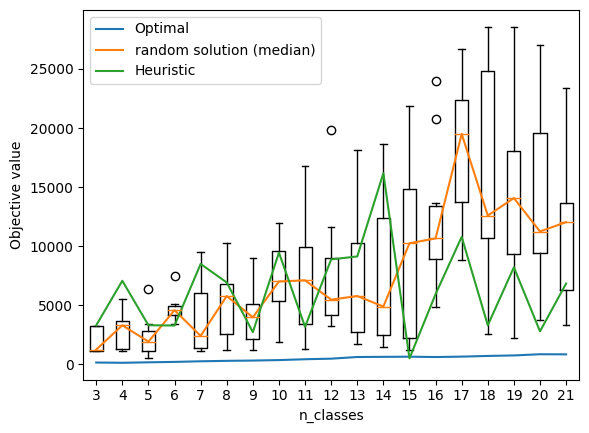

In [44]:
fig, ax = plt.subplots()
ax.set_xlabel("n_classes")
ax.set_ylabel("Objective value")
ax.boxplot(scores, labels=range(i_start,i_end))
ticks = ax.get_xticks()
ax.plot(ticks,ILP_scores, label='Optimal',)

ax.plot(ticks,np.median(scores, axis=0), label='random solution (median)')
ax.plot(ticks, heuristic_costs, label='Heuristic')
ax.legend()
fig.savefig('/home/ddeandres/spp_features_and_classes/performance_algorithms.pdf')

We can still improve the Heuristic by using the objective value to select the number of clusters.
iif the objective value and F1 score are correlated.
The Heuristic will still be much, much more efficient, time-wise then.

We have seen already that the clusters and features are quite similar. For the ToN-IOT and UNSW(10). So maybe the only problem is the # of clusters.

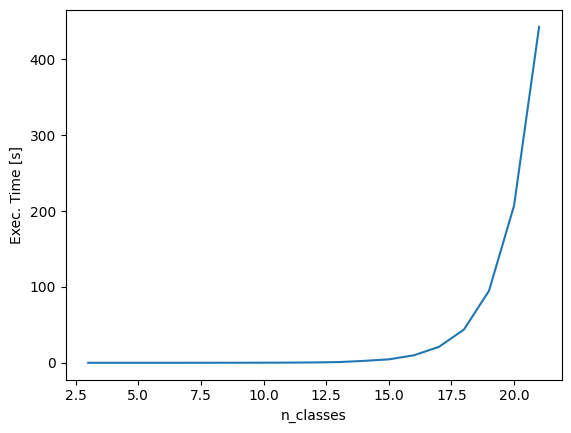

In [497]:
fig, ax = plt.subplots()
ax.set_xlabel("n_classes")
ax.set_ylabel("Exec. Time [s]")
ax.set_xticks(np.arange(i_start,i_end))
ax.plot(np.arange(i_start,i_end),ILP_exec_times)
fig.show()
# fig.savefig('/home/ddeandres/spp_features_and_classes/performance_algorithms.pdf')

In [2]:
import re
import os
import pandas as pd

### F1-analysis evaluation

In [1]:
random_experiment_c4_costs = {}
random_experiment_c6_costs = {}
random_experiment_c4_noF1_costs = {}
random_experiment_max_theta_costs = {}
directory_in_str = '/home/ddeandres/distributed_in_band/UNSW/cluster_model_analysis_results/correlation_analysis_v2'
directory = os.fsencode(directory_in_str)
pattern = re.compile('[0-9]+')

for file in os.listdir(directory):
    file_string = file.decode("utf-8")
    solution_file_path = os.path.join(directory_in_str, file_string)
    if os.path.isdir(solution_file_path) or 'csv' not in file_string:
        # skip directories and must be csv file
        continue
    exp_id = int(pattern.findall(file_string)[1])
    
    cluster_info = pd.read_csv(f'{directory_in_str}/{file.decode("utf-8")}', converters=dict.fromkeys(['Class List','Feature List'], literal_converter))
    cluster_info = cluster_info.reset_index(drop=True).drop(columns=['Unnamed: 0']).set_index('Cluster')
    
    sol_costs, sol_groups, sol_feats = encode_cluster_solution(cluster_info.loc[0:], costf='C4')
    random_experiment_c4_costs[exp_id]= sum(sol_costs)
    sol_costs, sol_groups, sol_feats = encode_cluster_solution(cluster_info.loc[0:], costf='C4 (no F1)')
    random_experiment_c4_noF1_costs[exp_id] = sum(sol_costs)
    sol_costs, sol_groups, sol_feats = encode_cluster_solution(cluster_info.loc[0:], costf='C6')
    random_experiment_c6_costs[exp_id] = sum(sol_costs)
    sol_costs, sol_groups, sol_feats = encode_cluster_solution(cluster_info.loc[0:], costf='max Theta')
    random_experiment_max_theta_costs[exp_id]= sum(sol_costs)

NameError: name 'os' is not defined

In [40]:
random_experiment_c4_costs

{10: 15700.722756021123,
 20: 2103.854647613981,
 35: 6934.2716856329225,
 23: 16896.4900124159,
 16: 3071.4436495565506,
 36: 13916.943185598397,
 8: 11964.573671845967,
 22: 10419.834856810421,
 3: 7331.837726894942,
 40: 12180.308740475552,
 34: 16900.512671405177,
 18: 6256.737276234699,
 2: 8212.363890881383,
 1: 27826.34346697472,
 28: 9152.130958240492,
 21: 26000.697844978957,
 12: 15310.57529193383,
 26: 12776.61195577002,
 31: 17390.023056350532,
 24: 16500.363941925076,
 13: 3656.5236598147067,
 30: 4350.537484181709,
 15: 6986.868036127207,
 33: 3372.391873883337,
 25: 17232.615647605548,
 9: 4825.718141752088,
 29: 2277.4882768207262,
 32: 14791.921437769264,
 14: 24126.70721115115,
 39: 7697.664424223108,
 11: 28733.016660936602,
 17: 15900.629377428582,
 7: 4578.319571517824,
 38: 22210.028190989335,
 6: 2221.532463986455,
 37: 22723.072856477746,
 4: 5848.822428593316,
 27: 11534.989740696732,
 5: 24633.20931003424,
 19: 26435.381240329993}

In [54]:
random_experiments_df = pd.read_csv('/home/ddeandres/spp_features_and_classes/correlation_experiment_F1_results_v2.csv',delimiter=';')
random_experiments_df['cost_c4'] = random_experiments_df['exp_id'].apply(lambda x: random_experiment_c4_costs[x])
random_experiments_df['cost_c4_no_F1'] = random_experiments_df['exp_id'].apply(lambda x: random_experiment_c4_noF1_costs[x])
random_experiments_df['cost_c6'] = random_experiments_df['exp_id'].apply(lambda x: random_experiment_c6_costs[x])
random_experiments_df['cost_max_Theta'] = random_experiments_df['exp_id'].apply(lambda x: random_experiment_max_theta_costs[x])
random_experiments_df = random_experiments_df.set_index('exp_id', drop=True)
random_experiments_df = random_experiments_df.assign(n_features_dist=np.nan)
random_experiments_df = random_experiments_df.astype(dtype={"n_features_dist": "object"})
random_experiments_df = random_experiments_df.assign(n_classes_dist=np.nan)
random_experiments_df = random_experiments_df.astype(dtype={"n_classes_dist": "object"})
for exp_id in list(random_experiments_df.index.values):
    file_path = f'/home/ddeandres/distributed_in_band/UNSW/cluster_model_analysis_results/correlation_analysis_v2/20CL_{exp_id}_SPP_solution.csv'
    cluster_info_df = pd.read_csv(file_path, converters=dict.fromkeys(['Class List','Feature List'], literal_converter))
    cluster_info_df['n_features'] = cluster_info_df['Feature List'].str.len()
    cluster_info_df['n_classes'] = cluster_info_df['Class List'].str.len()
    random_experiments_df.at[exp_id, 'n_features_dist'] = cluster_info_df['n_features'].to_list()
    random_experiments_df.at[exp_id, 'n_classes_dist'] = cluster_info_df['n_classes'].to_list()

In [55]:
random_experiments_df.sort_values('exp_id')

,F1_macro,F1_weighted,cost_c4,cost_c4_no_F1,cost_c6,cost_max_Theta,n_features_dist,n_classes_dist
exp_id,,,,,,,,
1,71.827601,77.442888,27826.343467,354.857763,357.708493,5.142237,"[3, 5, 5, 7, 5, 8, 4, 6, 6, 2, 3, 6, 5, 5, 5, ...","[1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,69.236603,75.826989,8212.363891,214.817572,217.714890,5.182428,"[8, 6, 6, 2, 6, 5, 6, 5, 5, 6, 5]","[2, 1, 2, 2, 2, 1, 3, 3, 1, 1, 2]"
3,69.776333,85.448486,7331.837727,154.052459,157.639178,5.947541,"[6, 5, 6, 7, 6, 3, 6, 6]","[3, 3, 3, 2, 5, 1, 1, 2]"
4,67.306375,85.272310,5848.822429,94.186814,97.694062,5.813186,"[5, 6, 6, 6, 6]","[1, 5, 3, 1, 10]"
5,71.782056,87.446694,24633.209310,314.425786,317.637465,5.574214,"[6, 3, 5, 5, 8, 6, 4, 6, 5, 7, 6, 5, 6, 5, 6, 3]","[1, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1]"
6,67.748497,83.416626,2221.532464,33.606256,37.659753,6.393744,"[7, 6]","[7, 13]"
7,69.582652,86.180757,4578.319572,93.927265,97.684161,6.072735,"[7, 6, 6, 6, 6]","[4, 11, 1, 2, 2]"
8,73.097840,79.783596,11964.573672,213.942004,217.637603,6.057996,"[5, 3, 6, 6, 7, 5, 7, 6, 2, 6, 6]","[1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 7]"
9,75.329168,87.237980,4825.718142,134.097049,137.688997,5.902951,"[6, 8, 7, 5, 5, 6, 6]","[2, 2, 2, 2, 1, 10, 1]"


In [57]:
random_experiments_df[['F1_macro','cost_c4', 'cost_c4_no_F1', 'cost_c6', 'cost_max_Theta']].corr(method='spearman')

,F1_macro,cost_c4,cost_c4_no_F1,cost_c6,cost_max_Theta
F1_macro,1.000000,0.634709,0.695685,0.696248,0.166417
cost_c4,0.634709,1.000000,0.978987,0.981801,0.078424
cost_c4_no_F1,0.695685,0.978987,1.000000,0.996435,0.046904
cost_c6,0.696248,0.981801,0.996435,1.000000,0.059850
cost_max_Theta,0.166417,0.078424,0.046904,0.059850,1.000000


<Axes: xlabel='cost_c4', ylabel='F1_macro'>

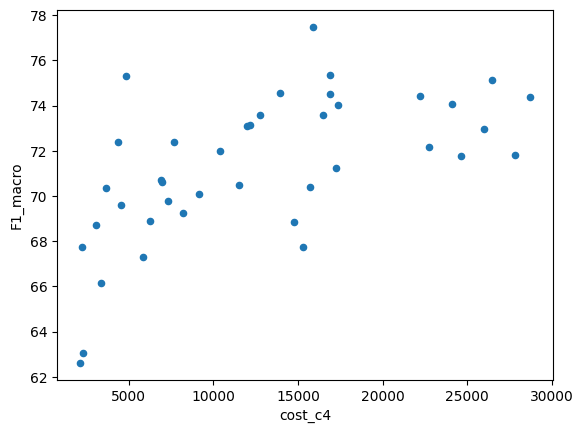

In [51]:
random_experiments_df.plot.scatter(x='cost_c4',y='F1_macro')

<Axes: xlabel='cost_c4_no_F1', ylabel='F1_macro'>

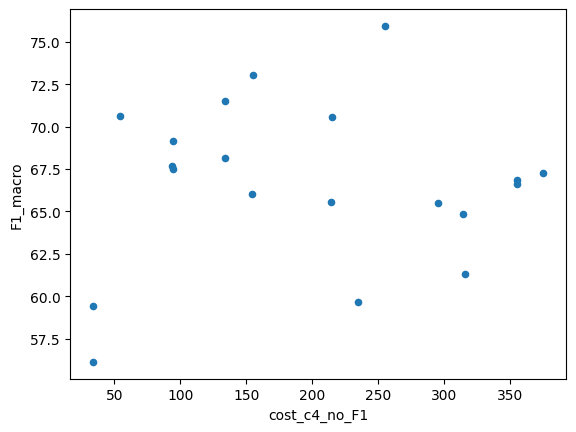

In [101]:
random_experiments_df.plot.scatter(x='cost_c4_no_F1',y='F1_macro')
# cost: 771.7526401792112
# F1: 80.15801615364094, 88.8571452713437

<Axes: xlabel='cost_c6', ylabel='F1_macro'>

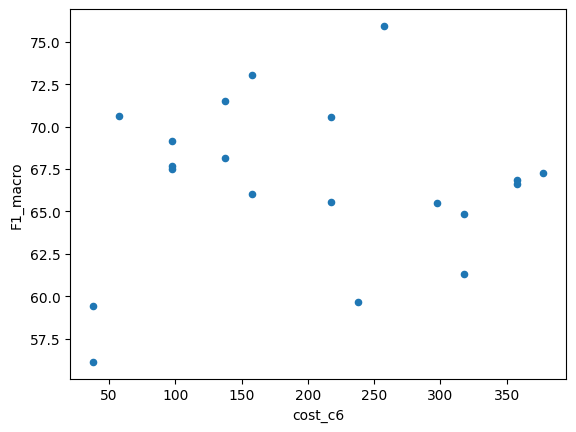

In [102]:
random_experiments_df.plot.scatter(x='cost_c6',y='F1_macro')